In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
from ipywidgets import *

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors, clone


from pyfrechet.metric_spaces import MetricData, Sphere, Euclidean
from pyfrechet.regression.frechet_regression import LocalFrechet, GlobalFrechet
from pyfrechet.regression.kernels import NadarayaWatson, gaussian, epanechnikov
from pyfrechet.regression.knn import KNearestNeighbours
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
M = Euclidean(2)
# M = Sphere(2)
mse = mean_squared_error(M)
m = lambda x: 5 + 5*x[:,0]**2 + np.sin(20 * x[:,0]) - 10*x[:,0]**3 

def gen_data(N, eps=0.1):
    x = np.random.rand(N*1).reshape((N,1))

    theta = m(x) + eps*np.random.randn(N)
#     return x, MetricData(M, theta.reshape((N,1)))
    y = np.c_[np.cos(theta), np.sin(theta)]
    return x, MetricData(M, y)

N = 400; eps = 0.5
X, y = gen_data(N, eps)


In [20]:
n

array([[ 0.93376669, -0.12212095]])

In [28]:
nw = NadarayaWatson(base_kernel=gaussian, bw=0.01).fit(X, y)
nw.predict(np.array([0.1]).reshape(1, -1))

array([ 0.79956658, -0.31203265])

In [32]:
clone(nw)

AttributeError: 'NadarayaWatson' object has no attribute 'x_train_'

In [6]:
gs = GridSearchCV(
    estimator=NadarayaWatson(base_kernel=gaussian),
    param_grid={'bw': np.logspace(-4, 0, 10)},
    scoring=mse
)
gs.fit(X, y)
gs.cv_results_

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/matthieubulte/Documents/university/phd/merf/pyfrechet/regression/kernels.py", line 21, in fit
    super().fit(X, y)
  File "/Users/matthieubulte/Documents/university/phd/merf/pyfrechet/regression/weighting_regressor.py", line 37, in fit
    X, y = check_X_y(X, y)
  File "/Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1122, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1143, in _check_y
    y = column_or_1d(y, warn=True)
  File "/Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1202, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (320, 2) instead.


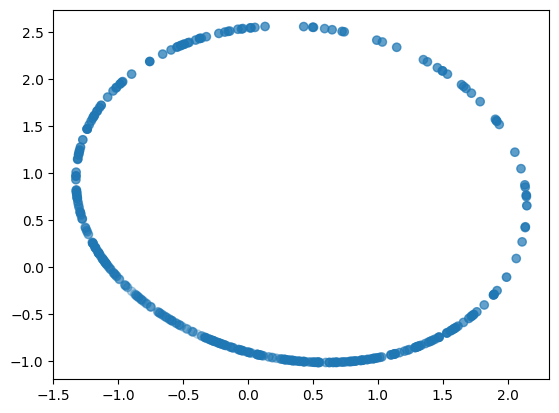

In [35]:

from sklearn.manifold import MDS


def mds_2d_scatter(data: MetricData):
    data.compute_distances()
    projections = MDS(
        n_components=2,
        normalized_stress='auto',
        dissimilarity='precomputed'
    ).fit_transform(data.distances)
    return projections

proj = mds_2d_scatter(y)
y_pred = GlobalFrechet().fit(X, y).predict(X)
errs = M.d(y, y_pred)

plt.scatter(proj[:,0], proj[:,1], alpha = errs / np.max(errs))

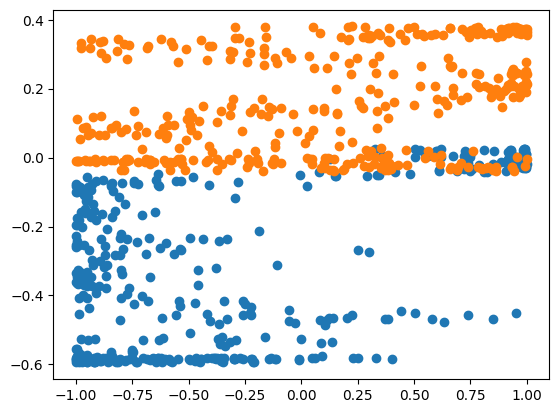

In [36]:
plt.scatter(y.data[:,1], y_pred.data[:,1])
plt.scatter(y.data[:,0], y_pred.data[:,0])

In [46]:
global_fr = GlobalFrechet().fit(x_train, y_train)

preds = global_fr.predict(x_test)
errs = M.d(y_test, preds)**2

errs.mean()

1.4777073728062866

In [47]:
from regression.forests import RandomForest 
from regression.trees import MedoidTree

y_train.compute_distances()
forest = RandomForest(MedoidTree(), 500, 0.75).fit(x_train, y_train)

preds = forest.predict(x_test)
errs = M.d(y_test, preds)**2

errs.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:   25.9s finished


0.2959713627167235

In [50]:
from regression.nadaraya_watson import NadarayaWatson
from regression.kernels import epanechnikov, gaussian

# for bw in [0.002, 0.004, 0.005, 0.006, 0.008, 0.01]:
# for bw in [0.002, 0.004, 0.005, 0.006, 0.008, 0.01]:
for bw in [0.0005, 0.001, 0.005, 0.01, 0.02]:
    nw = NadarayaWatson(gaussian, bw=bw).fit(x_train, y_train)
    preds = nw.predict(x_test)
    errs = Sphere(1).d(y_test, preds)**2
    print(bw, errs[~np.isnan(errs)].mean(), np.isnan(errs).sum())


0.0005 1.8415966224724576 96
0.001 1.8703192554728534 96
0.005 1.5945100703862107 95
0.01 2.0927977209740187 96
0.02 2.7829563490923186 97


/Users/matthieubulte/Documents/university/phd/merf/metric_spaces/sphere.py:14: RuntimeWarning: invalid value encountered in arccos
  return np.sum(np.square(np.arccos(np.dot(x,y.T))), axis=0)


<IPython.core.display.Javascript object>


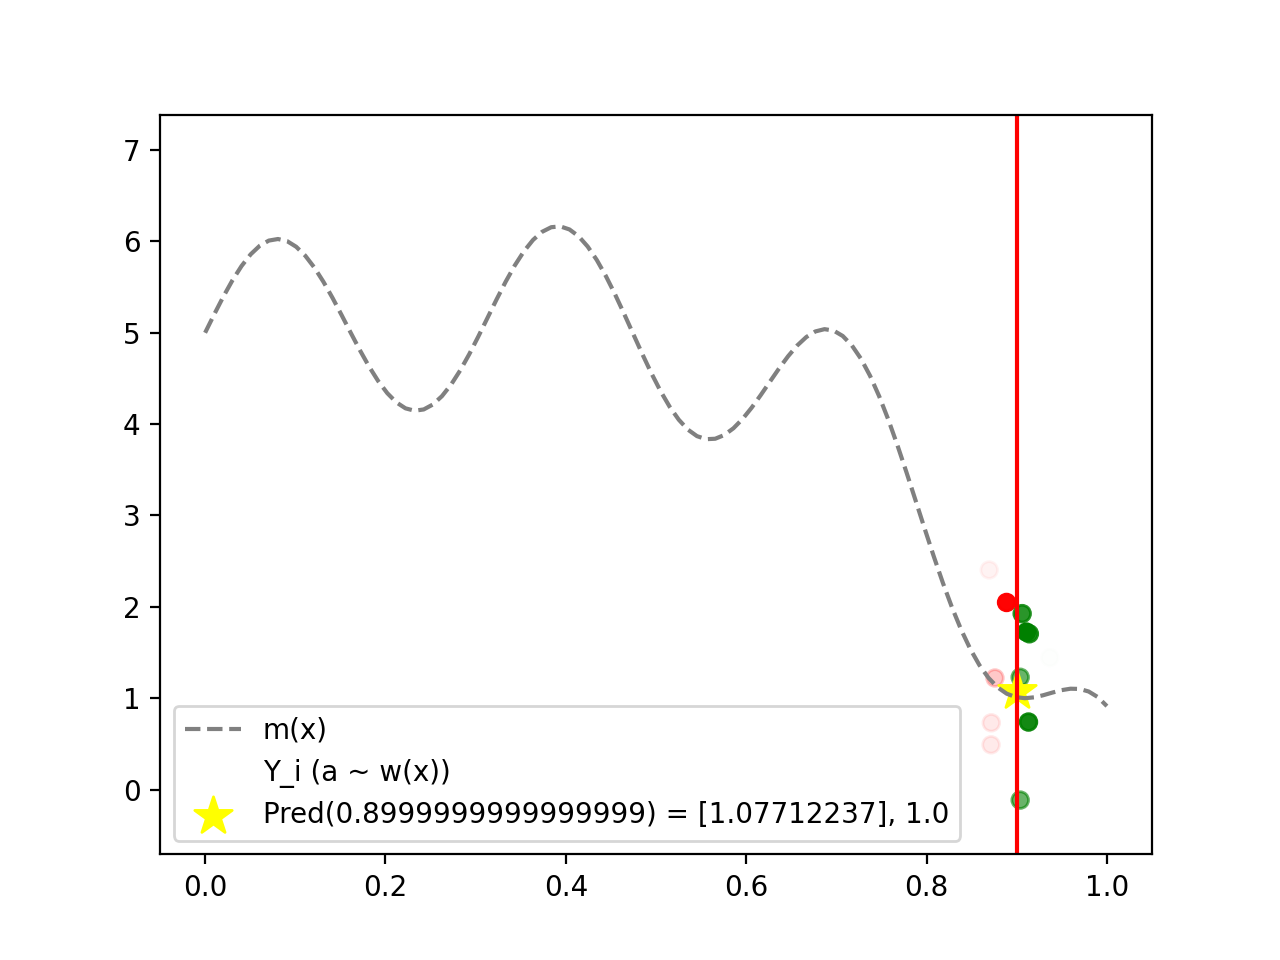

interactive(children=(FloatSlider(value=0.5, description='_x', max=1.5, min=-0.5), Output()), _dom_classes=('w…

In [52]:
%matplotlib notebook

est = LocalFrechet(gaussian, 0.01).fit(x_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
weights = est.weights_for([0.5])

ax.plot(np.linspace(0,1,100), m(np.linspace(0,1,100).reshape((100,1))), c='gray', linestyle='--', label='m(x)')
scat = ax.scatter(x_train, y_train.data, label='Y_i (a ~ w(x))')

eval_pt = ax.axvline(0.5, c='red')

pred_val = est.predict(np.array([0.5]))
pred_scat = ax.scatter([0.5], pred_val, marker='*', color='yellow', s=200, label=f'Pred(x) = {pred_val}')

ax.legend()

def update(_x = 0.5):
    weights = est.weights_for([_x])
    pred_val = est.predict(np.array([_x]))

    scat.set_alpha(np.abs(weights) / np.max(np.abs(weights)))
    scat.set_color(np.array(['red', 'green'])[0+(weights > 0)])
    
    eval_pt.set_xdata(_x)
    pred_scat.set_offsets([[_x, pred_val[0]]])
    pred_scat.set_label(f'Pred({_x}) = {pred_val}, {weights.sum()}')
    ax.legend()
    fig.canvas.draw_idle()

interact(update);

In [30]:
est.weights_for([0.4]).min()

0.0

In [76]:
y_ = np.zeros((2,5,5))
A = np.random.rand(25).reshape((5,5))
B = np.random.rand(25).reshape((5,5))

y_[0,:,:] = A
y_[1,:,:] = B

w = np.array([0.5, 0.5])

(w[:,None,None] * y_).sum(axis=0) - (A+B)/2


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

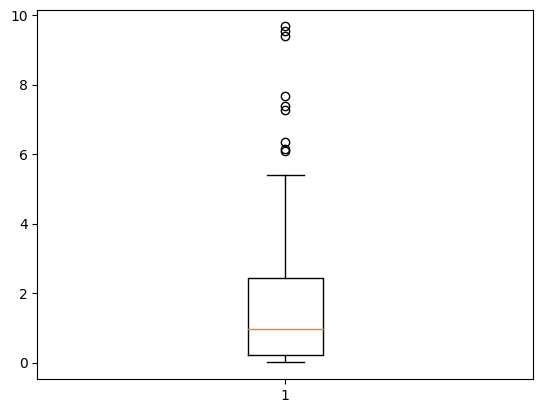

In [55]:
%matplotlib inline
plt.boxplot(errs[~np.isnan(errs)]);